<a href="https://colab.research.google.com/github/hasanenesguray/Homework/blob/main/Copy_of_CS412_HW4_2023_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS412 - Machine Learninig - 2022-2023
## Homework 4 - 100 pts


## Goal

The goal of this homework is two-fold:

*   Introduction to the Transfer Learning
*   Gain experience with three dimensional input data (colored images), and pretrained models (Part-A)

## Dataset
[**CelebA**](https://www.cs.toronto.edu/~kriz/cifar.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

**Download the data from Sucourse and upload it to your Google drive. In your Google drive, you need to have CelebA30k.zip and CelebA30k.csv uploaded. (Do not change the name of these files.) Reserve 10% of the training data for validation and %10 for test** and  **use the rest for development (learning your models). The test data (3000 samples) should only be used for testing at the end, and not model selection.**

## Task
Build a classifier with the Keras library function calls and pretrained models to *classify gender* in the CelebA dataset, completing the given code and without changing the network.


## Software: 

Keras is a library that we will use especially for deep learning, but also with basic neural network functionality of course. 

You may find the necessary function references here: 

http://scikit-learn.org/stable/supervised_learning.html

https://keras.io/api/

https://keras.io/api/applications/

When you search for Conv2d for instance, you should find the relevant function and explained parameters, easily.

## Submission: 
Fill this notebook. Follow the submission/answer requirements in SuCourse. 

##1) Initialize

*   First make a copy of the notebook given to you as a starter.

*   Make sure you choose Connect form upper right.

*   Make sure you change your runtime to GPU.

## 2) Load training dataset

*  Read from Keras library.

In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
# import the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from numpy import random
from PIL import Image

import keras
import tensorflow as tf
from keras import layers
from keras.layers import Input, Dense, Activation, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.layers import Dropout
from keras.regularizers import l2
from keras.regularizers import l1
np.random.seed(5)
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,img_to_array,array_to_img,save_img
import cv2
import os
% matplotlib inline

In [ ]:
data = pd.read_csv('/content/drive/My Drive/CS412/Homeworks/celeba_30k.csv') # enter the file path on your drive for the csv file
data.head()

In [ ]:
gender_data = data[['image_id', 'Male']].copy()
gender_data.head()

,image_id,Male
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0


In [ ]:
#this will extract the contents of the zip file into a folder named data
#do not extract the zip into your google drive (i.e don't use drive/My Drive in the right path since it slows down the process)
#only change the left path

!unzip "/content/drive/My Drive/celeba_30k/celeba_30k.zip" -d "/content/data"

In [ ]:
first_image_path = os.path.join("/content/data/celeba_30k/", gender_data.loc[0,"image_id"])
img = Image.open(first_image_path) 

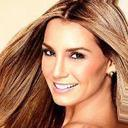

In [ ]:
img

##3) Visualizing/Understanding the dataset

- Display five random images together with their labels

- Display statistics about the dataset, such as distribution of labels, etc.


In [ ]:
# plot random 5 images in your dataset with their labels



##4) Split the dataset as train (also called development) (80%) and validation (10%) and test (10%) set. You'll tune the hyperparameters using the validation set and evaulate the model on the unseen test set. 

In [ ]:
gender_data["Male"] = gender_data["Male"].replace({0: 'Female', 1: 'Male'}) 

In [ ]:
# Split 80-10-10
from sklearn.model_selection import train_test_split 
train_df, val_df = train_test_split(gender_data, test_size=0.1, random_state=42, shuffle = True)
train_df, test_df = train_test_split(train_df, test_size=1/9, random_state=42, shuffle = True) #since 0.9 * (1/9) = 0.1


In [ ]:
data_path = "/content/data/celeba_30k" #where you extracted the zip file
total_train = train_df.shape[0]
total_validate = val_df.shape[0]
batch_size=...

#create the test_generator accordingly

from keras.preprocessing.image import ImageDataGenerator, load_img


train_datagen = ImageDataGenerator() #augmentations for training set... https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    data_path, 
    x_col='image_id',
    y_col='Male',
    class_mode='categorical',
    target_size=(224,224), #this will resize the image, you can change the size
    batch_size=batch_size
)



val_datagen = ImageDataGenerator() #augmentations for validation set
val_generator = val_datagen.flow_from_dataframe(
    val_df, 
    data_path, 
    x_col='image_id',
    y_col='Male',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=batch_size
)

##5) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 model. This is pre-trained on ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

First, you need to pick which layer of VGG-16 you will use for feature extraction. The very last classification layer (called "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

You'll also load the pretrained weights from ImageNet by specifying weights='imagenet'. 


In [ ]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', input_shape = (224,224,3), include_top=False)
base_model.summary()


By setting the trainable attribute to False, we ensure that the original (ImageNet) weights of the model will remain constant.

Note that it is possible to adjust the number of trainable layers by modifying the for loop.

In [ ]:
#By setting the trainable attribute to False, we ensure that the original (ImageNet) weights of the model will remain constant.

for layer in base_model.layers:
    layer.trainable = False

We need a binary classifier (Male/Female) which we will add manually on top of the pre-trained model. This layer is usually called "classification head". 


In [ ]:
def gender_model(base_model, img_shape = (224,224,3)):
    
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=img_shape) 
    
    # Forward pass to get the output of the last pooling layer
    X = base_model(inputs)

    #Flatten the output
    X = ...
    
    # Define the new binary classification head 
    
    X = ...
        
    outputs = ...
    model = tf.keras.Model(inputs, outputs)
    
    return model

## 6-) Fine-Tuning the Model

Since our base model is trained on a different dataset (ImageNet), we still need to tune the hyperparameters. 
Tune learning rate (most important), number of epochs and batch size.

In [ ]:
# with generators fit method should be used like below:
# optimizer could be SGD from tf.keras.optimizers or something else if you wish to experiment
# loss could be Binary cross entropy from tf.keras.losses
model.compile(optimizer=...),
              loss=...,
              metrics=['accuracy'])
history = model.fit(train_generator, batch_size=...,
                              epochs=..., validation_data = val_generator, workers = 8) #workers loads the data in parallel


## 7) Train the Network with  Tuned Parameters

In [ ]:
#Train the model with the tuned parameters
#You can also use methods like early stopping based on validation loss to counter overfitting, reducing the learning rate on plateau etc.
#Keep the batch size small (i.e 8 or 16) if you get a memory error


#https://keras.io/api/callbacks/early_stopping/
#https://keras.io/api/callbacks/reduce_lr_on_plateau/
 
#model.compile(loss=..., optimizer=..., metrics=['accuracy'])
#history = model.fit(...)

#You can plot training/validation loss using history

# Report your results

#...



## 8) Test your classifier on Test set

- Predict the labels of testing data **using the best model that you have selected according to your validation results** and report the accuracy. 

In [ ]:
from sklearn.metrics import accuracy_score
# Load test data





# Predict




# Report your result





